In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import wisps
import wisps.simulations as wispsim

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [4]:
import matplotlib as mpl
from scipy import stats

In [5]:
import splat
from scipy import integrate

In [6]:
#import pymc stuff 
import numba
import pymc3 as pm

In [7]:
pnts=wisps.OBSERVED_POINTINGS

In [8]:
spgrid=np.arange(20, 38)

In [9]:
ras=[p.coord.ra for p in pnts]
decs=[p.coord.dec for p in pnts]
dlimits=np.array([np.array([p.dist_limits[k] for k in spgrid ]) for p in pnts])

In [10]:
h = 380.0

In [11]:
import splat.simulate as spsim

In [12]:
spsim.volumeCorrection(pnts[0].coord, 1., 1000.)

0.4165290249037164

In [13]:
wispsim.custom_volume_correction(pnts[0].coord, 1., 1000.)

0.2372990544014378

In [14]:
r, z=wispsim.convert_to_rz(pnts[0].coord.ra, pnts[0].coord.dec, np.linspace(1., 10000., 10000))

In [15]:
plt.plot(r, wispsim.density_function(r, z, 380), label=r'$sech^2$')
plt.plot(r, spsim.galactic_density_juric(r, z).value, label='juric-splat')
plt.ylabel(r'$\rho (r, z)$')
plt.xlabel('r (pc)')
plt.legend()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


In [16]:
dmaxses=np.logspace(0.5, 4., 1000)

In [17]:
vcs1=[wispsim.custom_volume_correction(pnts[0].coord,1., dmax) for dmax in dmaxses]

In [18]:
vcs2=[spsim.volumeCorrection(pnts[0].coord,1., dmax) for dmax in dmaxses]

In [19]:
plt.plot(dmaxses, vcs1, label=r'$sech^2$')
plt.plot(dmaxses, vcs2, label='juric-splat')
plt.ylabel('Vc')
plt.xlabel('r (pc)')
plt.legend()

In [20]:
plt.plot(z, wispsim.density_function(r, z, 380), label=r'$sech^2$')
plt.plot(z, spsim.galactic_density_juric(r, z).value, label='juric-splat')
plt.ylabel(r'$\rho (r, z)$')
plt.xlabel('z (pc)')
plt.legend()

In [21]:
from pymc3.distributions import Interpolated

In [22]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

In [23]:
from wisps.simulations import logp

In [24]:
def run_coordinate(pnt):
    
    simple_model = pm.Model()

    traces=[]
    for spt in spgrid:

        ras=pnt.coord.ra
        decs=pnt.coord.dec
        dlimits=pnt.dist_limits[spt]
        dmaxs=dlimits[0]
        dmins=dlimits[1]

        robsmax, zobsmax=wispsim.convert_to_rz(ras,decs, dmaxs)
        robsmin, zobsmin=wispsim.convert_to_rz(ras,decs, dmins)


        with pm.Model() as model:
            lower_r=robsmin
            upper_r=robsmax

            upper_z=np.nanmax([zobsmax, zobsmin])
            lower_z=np.nanmin([zobsmax, zobsmin])

            r=pm.Uniform('r', lower=lower_r, upper=upper_r)
            z=pm.Uniform('z', lower=lower_z, upper=upper_z)



            like = pm.Potential('lnlike', logp(r,z,h))
            d=pm.Deterministic('d', (r**2+z**2)**0.5)


            trace = pm.sample(tune=10, draws=int(1e3), cores=4)
            traces.append(trace)
            
    return traces, model


In [25]:
traces, model=run_coordinate(pnts[0])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, r]
Sampling 4 chains: 100%|██████████| 4040/4040 [00:02<00:00, 1478.97draws/s]
The acceptance probability does not match the target. It is 0.9515706897585218, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8862398753589307, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9142378627766959, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, r]
Sampling 4 chains: 100%|██████████| 4040/4040 [00:02<00:00, 1550.31draws/s]
The acceptance probability does not match the target. It is 0.9078687437796706, but should be close to 0.8. Try to increase the 

In [26]:
%matplotlib inline

Posterior distributions after 18 iterations.


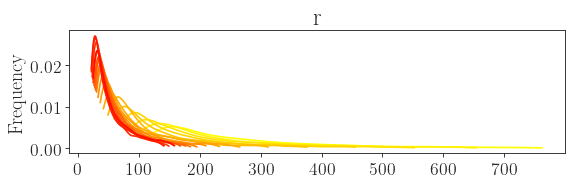

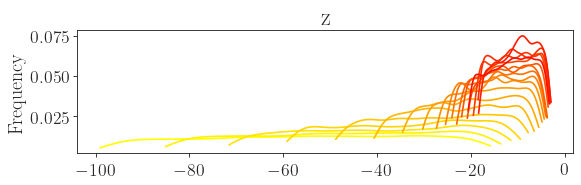

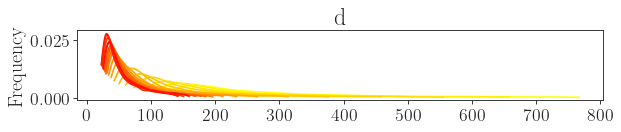

In [27]:

print('Posterior distributions after ' + str(len(traces)) + ' iterations.')
cmap = mpl.cm.autumn
for param in ['r', 'z', 'd']:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.ylabel('Frequency')
    plt.title(param)

plt.tight_layout();
plt.savefig(wisps.OUTPUT_FIGURES+'/distance_posteriors.pdf')

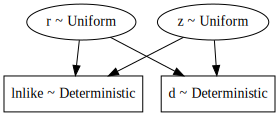

In [29]:
pm.model_to_graphviz(model)

In [30]:
norm = mpl.colors.Normalize(vmin=20., vmax=37.0)

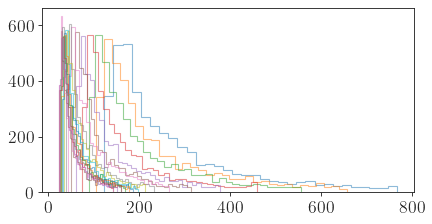

In [31]:
for trace in traces:
    hist=plt.hist((trace['r']**2+trace['z']**2)**0.5, histtype='step', bins='auto', alpha=0.5)

In [32]:
import seaborn as sns 
cmap= sns.dark_palette("palegreen", as_cmap=True)

In [33]:
all_rs=np.concatenate([tr['r'] for tr in traces])
all_zs=np.concatenate([tr['z'] for tr in traces])

In [34]:
len(traces)

18

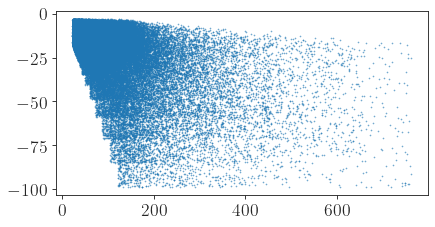

In [40]:
plt.scatter(all_rs, all_zs, s=.1)

In [37]:
xdfcghvj

NameError: name 'xdfcghvj' is not defined

In [ ]:
import pickle
with open(wisps.OUTPUT_FILES+'/bayesian_pointings.pkl', 'wb') as file:
           pickle.dump( traces,file)

In [ ]:
import pickle

In [ ]:
with open('/users/caganze/desktop/direction.pkl', 'wb') as file:
           pickle.dump( pnts,file)

In [ ]:
d=np.load('/users/caganze/bayesian_pnts.npy',  allow_pickle=True)

In [ ]:
d.shape

In [ ]:
r_array=(np.array([[d[1][idx2][idx]['r'] for idx in np.arange(1000)] for idx2 in np.arange(18)]))
z_array=(np.array([[d[1][idx2][idx]['z'] for idx in np.arange(1000)] for idx2 in np.arange(18)]))

In [ ]:
r_array1=(np.array([[d[0][idx2][idx]['r'] for idx in np.arange(1000)] for idx2 in np.arange(18)]))
z_array1=(np.array([[d[0][idx2][idx]['z'] for idx in np.arange(1000)] for idx2 in np.arange(18)]))

In [ ]:
plt.scatter(r_array, z_array,c=logp(r_array, z_array, 380), s=.1, cmap=cmap)
plt.scatter(r_array1, z_array1,c=logp(r_array1, z_array1, 380), s=.1, cmap=cmap)


In [ ]:
r_array.shape